<img width=200 src="ENSL.svg"/> 
author: Aurélien Garivier

# An experiment with the MNIST dataset


The Mnist dataset provides a (somewhat old but) very classical example of Machine Learning. The goal is simple and useful: recognize hand-written digits. This was an important challenge for the postal companies in the 1980s.  

It is available on the webpage of <a href="http://yann.lecun.com/exdb/mnist/">Yann LeCun</a>, a very famous researcher in Machine Learning in general and neural networks in particular. 

</p>

In [1]:
# loading a lot of facilities for numerical computations and graphs
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 6) # to have larger plot
seed(240979) #initialize random number generator

# set working directory
workingdir = './'

Populating the interactive namespace from numpy and matplotlib


## 1. Loading the data set

### 1.1 Description of the data set
The MNIST data contains $n\_tot=70000$ images of size $dimX\times dimY=28\times28$, and their *labels* (a digit between $0$ and $9$). 
The images are stored as lines of the matrix *mnist.data*. 
Each image can be reshaped as a matrix $im \in \mathcal{M}_{dimX, dimY}(\mathbb{R})$, where $im[i,j]$ is the intensity level of pixel (i,j): 0 means 'white', 255 means 'black'.

The labels, stored in *mnist.target*, are numbers (here, we cast them to integers) between $0$ and $9$. 

In [31]:
# deprecated...
#from sklearn.datasets import fetch_mldata # si besoin: sudo pip install -U scikit-learn ou (pour une install locale)  pip install --user --install-option="--prefix=" -U scikit-learn
#mnist = fetch_mldata('MNIST original', data_home='./')
#mnist.target = mnist.target.astype(int) # by default the digits are floating numbers: convert to integers

# new way to load MNIST dataset
from sklearn.datasets import fetch_openml
mnist = lambda:None
mnist.data, mnist.target = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
mnist.target = [int(d) for d in mnist.target]

# alternative: loading a small dataset instead
#from sklearn import datasets, svm, metrics
#from sklearn.model_selection import train_test_split
#digits = datasets.load_digits()
#_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
#for ax, image, label in zip(axes, digits.images, digits.target):
#    ax.set_axis_off()
#    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
#    ax.set_title("Training: %i" % label)
#n_samples = len(digits.images)
#mnist = lambda:None
#mnist.data = digits.images.reshape((n_samples, -1))
#mnist.target = digits.target

# defining general variables for use throuhout the notebook  
n_tot = len(mnist.data)
dimX = int(sqrt(len(mnist.data[0]))); dimY = dimX # nb of pixels in each dimension
nc = len(unique(mnist.target)) # number of classes

print("Loaded %d images of size %dx%d"%(n_tot, dimX, dimY))
print("Number of classes: %d"%(nc))
print("Classes:")
print(sorted(unique(mnist.target)))

Loaded 70000 images of size 28x28
Number of classes: 10
Classes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 1.2 What does the data look like?

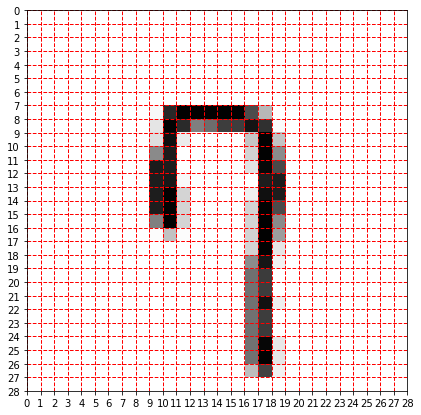

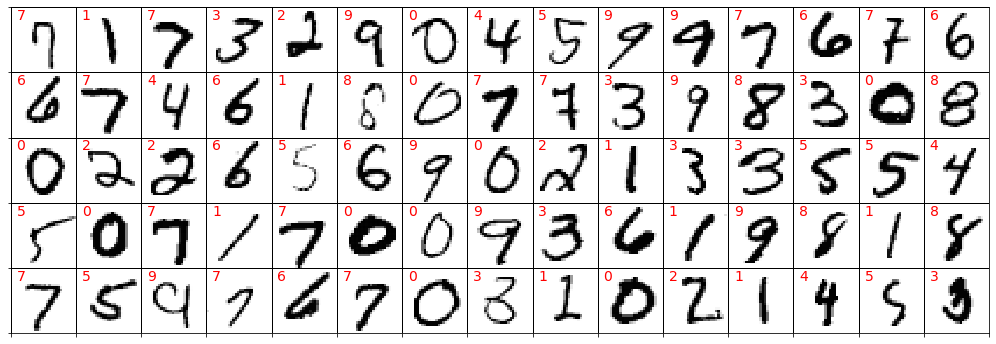

In [32]:
# Showing one image 
figure(figsize = (7,7))
ii = random.randint(0, n_tot-1)
plt.imshow(reshape(mnist.data[ii], [dimX, dimY], order='C'), cmap="Greys", interpolation="none") # or "nearest"
ax = plt.gca()
ax.set_xticks(arange(-0.5, dimX, 1))
ax.set_yticks(arange(-0.5, dimY, 1))
ax.set_xticklabels(arange(0, dimX+1, 1))
ax.set_yticklabels(arange(0, dimY+1, 1))
ax.grid(color='r', linestyle='--', linewidth=1)
plt.show()

# Showing a few images in the dataset with their labels
nbRows = 5
nbCols = 15
I = [[0 for k in range(nbCols)] for j in range(nbRows)]
I[0] = [random.randint(0, n_tot-1) for k in range(nbCols)]
I[0][0] = ii
M = np.concatenate([reshape(mnist.data[i], [dimX,dimY], order='C') for i in I[0]], axis=1)

for j in range(1, nbRows):
    I[j] = [random.randint(0, n_tot-1) for k in range(nbCols)]
    M = concatenate([M, np.concatenate([np.reshape(mnist.data[i], [dimX, dimY], order='C') for i in I[j]], axis=1)], axis=0)
plt.imshow(M, cmap="Greys", interpolation="none")
for j in range(nbRows):
    for k in range(nbCols):
        plt.text(dimX*k+2, dimX*j+5, mnist.target[I[j][k]], fontsize=14, color="red")
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, dimX*nbCols, dimX))
ax.set_yticks(np.arange(-0.5, dimY*nbRows, dimY))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='k', linestyle='-', linewidth=1)

## 2. What is the goal?


### 2.1 Classifiers
We must construct a *classifier* $\mathcal{M}_{dimX, dimY}(\mathbb{R})\to \{0,\dots,9\}$ which maps every possible data $X$ (an image) to a label $d$ (a digit).
This is a **classification problem** with $n_c = 10$ classes.

Classically, this classifiers is assumed to take as input:
  * a matrix (table) $X\in\mathcal{M}_{n, p}(\mathbb{R})$, where $X_{i,.}$ contains the relevant information on the $i^{th}$ example (here, image);
  * a vector (list) $y\in\mathcal{Y}^n$ of *labels* (here, for each image, the corresponding digit).

In [33]:
class Classifier: # abstract base class, just providing a template for the classifiers
    def __init__(self):
        pass
    
    def fit(self, X, y): 
        pass
    
    def predict(self, X): # returns a digit (0,1,...,9) for each line of X
        return(apply_along_axis(self.predictOne, axis=1, arr=X))
    
    def predictOne(self, x):
        #return(nc) # nc=10 means "I don't know"
        return(random.choice(range(nc))) # random choice

randomClassifier = Classifier()

### 2.2 Dividing the data into a training and a testing set


We will separate the data into two sets: the *training set* and the *testing set.
We will use the *training set* only to teach the machine recognize the digits.  
The *testing set*, on the other hand, will be used to evaluate the performance of our classifier. It should *not* be used in the construction of the classifier! In usual challenges, it is hidden to the participants.

In [40]:
I = [1,2]
mnist.target[I]

TypeError: list indices must be integers or slices, not list

In [42]:
class DataSet:
    def __init__(self, data, target): 
        self.data = data # input : images
        self.X = data # default: features = data itself
        self.target = target # output: labels
        self.n = len(data)
        
# defining the dataSets
# training set: the images we may use to construct the classifier

n_train = 1000
I = random.choice(range(n_tot), n_train, replace=False)
trainingSet = DataSet(mnist.data[I, :], [mnist.target[i] for i in I]) 

# testing set: we may not use them, except at the end to assert the quality of the classifier
mask = np.ones(n_tot, dtype=bool) #np.ones_like(a,dtype=bool)
mask[I] = False
testingSet = DataSet(np.array(mnist.data)[mask, :], np.array(mnist.target)[mask])

In [43]:
print("Training set of size %d"%(trainingSet.n))
print("Testing set of size %d"%(testingSet.n))
print("Histogram of the labels in the training set:")
print(np.histogram(trainingSet.target, [-0.5+k for k in range(11)])[0])
print("Histogram of the labels in the testing set:")
print(np.histogram(testingSet.target, [-0.5+k for k in range(11)])[0])

Training set of size 1000
Testing set of size 69000
Histogram of the labels in the training set:
[ 93 107 100 109  97 101  85 107  91 110]
Histogram of the labels in the testing set:
[6810 7770 6890 7032 6727 6212 6791 7186 6734 6848]


### Evaluating a classifier
The most natural performance measure is the *proportion of misclassified images*. 
One may compute the *training error* 
$$ L_{mis}^{train}(classifier) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}\{classifier\big(train\_images[i]\big) \neq train\_labels[i]\big)\}$$ 
and the *testing error*
$$ L_{mis}^{test}(classifier) = \frac{1}{n_{test}} \sum_{i=1}^{n_{test}} \mathbb{1}\{classifier\big(test\_images[i]\big) \neq test\_labels[i]\big)\}\;.$$ 
The testing error is the only correct estimator of the performance of the classifier on future data, because the training sample is used to train the classifier (after all, it may just store them and learn the answers by heart).

Of course, for the purely random classifier, the results are predictible! (guess the results before running the next cell).

In [44]:
def evaluate(classifier, X, y): # (X,y) is a testing set
    return(mean(classifier.predict(X) != y))

print("Random classifier: misclassification on the training set=%g"%(evaluate(randomClassifier, trainingSet.X, trainingSet.target)))
print("Random classifier: misclassification on the testing set=%g"%(evaluate(randomClassifier, testingSet.X, testingSet.target)))


Random classifier: misclassification on the training set=0.907
Random classifier: misclassification on the testing set=0.900667


## 3. Without Machine Learning: designing a classifier by hand


### 3.1 An expert system
The first, most natural approach, is to try to recognize the features from a few characteristics. For example:
  - the contour of a '0' is black, while its center is white,
  - a '1' has a more or less vertical bar in the middle, and nothing else,
  - the top, bottom, and second diagonal of a '2' are black,
  - ...
  
Thus, it seems natural to build simple "detectors" that sense the presence or absence of writing in the top, bottom, left, right, center, outer part, and diagonals of the image. Then, we can cook a classifier based on these characteristics of the image. 

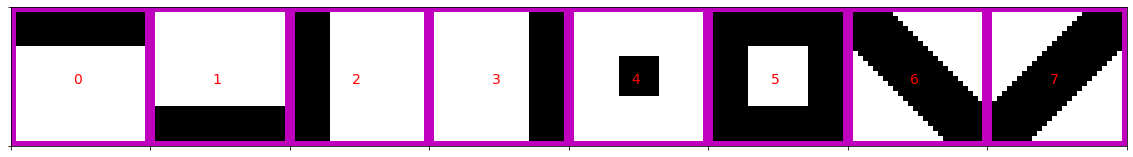

In [45]:
from scipy.linalg import toeplitz # for trigonal matrices

# hand-made masks to detect some characteristics of the images

top = 0; Mtop = np.concatenate((np.ones(28*8), np.zeros(28*20)))
bottom = 1 ; Mbottom = np.concatenate((np.zeros(28*20), np.ones(28*8)))
left = 2; Mleft = np.tile(np.concatenate((np.ones(8), np.zeros(20))), 28)
right = 3; Mright = np.tile(np.concatenate((np.zeros(20), np.ones(8))), 28)
center = 4; Mcenter = np.concatenate((np.zeros(28*10), np.tile(np.concatenate((np.zeros(10), np.ones(8), np.zeros(10))), 8), np.zeros(28*10)))
outside = 5; Moutside = np.concatenate((np.ones(28*8), np.tile(np.concatenate((np.ones(8), np.zeros(12), np.ones(8))), 12), np.ones(28*8)))
diag1 = 6; Mdiag1 = np.reshape(toeplitz(np.concatenate((np.ones(8), np.zeros(20)))), [28*28])
diag2 = 7; Mdiag2 = np.reshape(np.flipud(toeplitz(np.concatenate((np.ones(8), np.zeros(20))))), [28*28])

masks = [Mtop, Mbottom, Mleft, Mright, Mcenter, Moutside, Mdiag1, Mdiag2]
p = len(masks)

# Show the masks

M = np.concatenate([np.reshape(masks[i], [dimX,dimY], order='C') for i in range(p)], axis=1)
plt.imshow(M, cmap="Greys", interpolation="none")
for j in range(p):
    plt.text(dimX*j+12, 15, j, fontsize=14, color="red")
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, dimX*p, dimX))
ax.set_yticks(np.arange(-0.5, dimY, dimY))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='m', linestyle='-', linewidth=10)

The masks will be used to sum the "total amount of writing" in each of the chosen areas of the images. 
Each image will be represented by a tuple of values called *features*.
The first job is thus to build, for each image, its feature vector. 
Here, the feature vector is made of $p=8$ boolean features, which indicate whether each zone is "written" or not.

We must choose a *threshold* for each mask to decide whether the zone is "written" or not. 
We could hand-tune these thresholds; for simplicity, here, we chose that a zone is "written" if less than $\alpha = 45\%$ of the images in the training set are "more written" in that zone.

Doing so, we introduce an important intermediate step: for every image we compute a *feature vector* $x$=featureVector(image), and then the goal is to construction a mapping $\psi:x\mapsto \{0,\dots,d\}$. The classifier is of the form: $image \mapsto \psi\big(featureVector(image)\big)$.

In [46]:
class FeatureMaker: # abstract class, serves as a template for all feature making classes
    def __init__(self):
        self.p = dimX*dimY # number of features
    
    def computeFeatures(self, image):
        return(np.array(image)/255) # by default, the feature is the input itself
    
    def computeAllFeatures(self, dataSet): # stores the features in vector X of the dataSet
        dataSet.X = np.array([self.computeFeatures(im) for im in dataSet.data]) 


Features: 
[False, False, False, False, False, False, False, False]


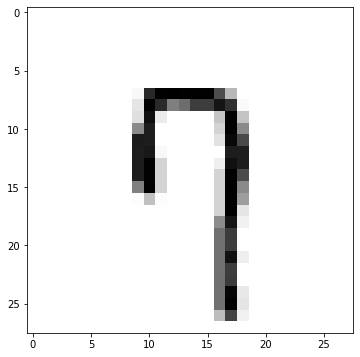

In [50]:
class LogicalFeatureMaker(FeatureMaker):    
    def __init__(self, masks, thresholds=[]):
        self.masks = masks
        self.p = len(masks)
        self.thresholds = thresholds

    def computeFeatures(self, image):
        return([self.isWritten(image, self.masks[k], self.thresholds[k]) for k in range(self.p)])
                
    def isWritten(self, image, mask, threshold): 
        return(sum(image*mask) > threshold)

    def computeThresholds(self, dataSet):
        self.trainingSet = dataSet
        self.thresholds = [self.computeThreshold(mask) for mask in masks]
          
    def computeThreshold(self, mask):
        alpha = 0.45 # value obtained after some hand tuning...
        return(sorted([sum(im*mask) for im in trainingSet.data])[int(alpha*len(trainingSet.data))])

logicalFeatureMaker = LogicalFeatureMaker(masks, 8000 * np.array([0.5, 0.7, 0.1, 0.2, 0.7, 1.3, 2, 2]))
logicalFeatureMaker.computeThresholds(trainingSet) # overwrite arbitrary features 

plt.imshow(np.reshape(mnist.data[ii], [dimX, dimY], order='C'), cmap="Greys", interpolation="none")
print("Features: ")
print(logicalFeatureMaker.computeFeatures(mnist.data[ii]))

logicalFeatureMaker.computeAllFeatures(trainingSet) # updates trainingSet.X
logicalFeatureMaker.computeAllFeatures(testingSet) # updates testingSet.X

In [51]:
class HandMadeClassifier(Classifier):
    def __init__(self):
        self.featureMaker = logicalFeatureMaker
        self.p = logicalFeatureMaker.p
        
    def fit(self, X, y): # no data fitting!
        pass
    
    def predict(self, X):
        return([self.predictOne(x) for x in X])

    def predictOne(self, x):
        if  x[outside] and not x[center]:
            return(0)
        elif not x[left] and not x[right] and x[center] and not x[outside]:
            return(1)
        elif x[top] and x[diag2] and x[bottom] and not x[center]:
            return(2)
        elif x[top] and x[bottom] and x[center] and x[right]:
            return(3)
        elif x[diag2] and x[bottom] and not x[top] and not x[outside]:
            return(4)
        elif x[top] and x[bottom] and x[diag1] and not x[diag2]:
            return(5)
        elif x[top] and x[center] and x[bottom] and x[diag1] and not x[right]:
            return(6)
        elif x[top] and x[diag2] and not x[bottom] and not x[left]:
            return(7)
        elif x[top] and x[center] and x[bottom] and x[left]:
            return(8)
        elif x[top] and x[center] and x[bottom] and x[right] and not x[left]:
            return(9)
        else:
            # return(10) # 10 means: I don't know
            return(random.randint(0, 10)) # random guessing

In [52]:
handMadeClassifier = HandMadeClassifier()

trainingError = evaluate(handMadeClassifier, trainingSet.X, trainingSet.target)
print("training error: %g" % (trainingError))

testingError = evaluate(handMadeClassifier, testingSet.X, testingSet.target)
print("testing error: %g" % (testingError))

training error: 1
testing error: 0.806348


* -> Training and testing error are slightly better than random classification (90%), but not by far! They are really not satisfactory. It would require a huge effort to obtain decent performance. 

* One can observe here, as expected, that training and testing errors coincide statistically.

### 3.2 Questions
* Try improving the decision rule coded in the function HandMadeClassifier.predictOne
* Try adding new, relevant features. What is the best score you can reach?

## Nearest-neighbor classifier
Distance-based methods consider some notion of *distance* in the feature space, and assume that if to feature vectors are close, then the corresponding targets are likely to be equal.

### 7.1 What distance?
The first problem, of course, is to provide the feature space with a relevant distance. There are a few default choices, and in particular the Euclidian distance (o $L^2$ distance) in $\mathbb{R}^p$ :
$$d(x,y) = \sqrt{\sum_{i=1}^p (x_i-y_i)^2}$$

Is this distance really relevant on images? 
A better alternative would be the *earthmoving distance*, but it is much more costly in computation time and we will see that the $L^2$ distance already performs well.


If you code it by yourself, the result will be good butthe computation time ridiculously high...

The classifiers of scikitlearn are usually well coded, and much more efficient than a few "quick and dirty" lines.



In [55]:
import time

n_train = 60000
I = random.choice(range(n_tot), n_train, replace=False)
trainingSet = DataSet(np.array(mnist.data)[I, :], np.array(mnist.target)[I]) 

# testing set: we may not use them, except at the end to assert the quality of the classifier
mask = np.ones(n_tot, dtype=bool) #np.ones_like(a,dtype=bool)
mask[I] = False
testingSet = DataSet(np.array(mnist.data)[mask, :], np.array(mnist.target)[mask])

from sklearn.neighbors import KNeighborsClassifier
k = 1
nearestNeighborsClassifier2 = KNeighborsClassifier(n_neighbors=k) # L2 distance is the default
nearestNeighborsClassifier2.fit(trainingSet.X, trainingSet.target)

J = random.choice(range(len(testingSet.target)), 1000, replace=False)

start_time = time.time()
print("Proportion of misclassified images in testing set: %g" %(evaluate(nearestNeighborsClassifier2, testingSet.X[J, :], testingSet.target[J])))
print("elapsed: %g seconds"%(time.time()-start_time))

Proportion of misclassified images in testing set: 0.035
elapsed: 1.32675 seconds



### 7.2 k-nearest neighbors
The idea of the k-nearest neighbors classifier is very simple: 
* choose an integer $k$;
* if you want to guess which target corresponds to some $x$ in the feature space, then simply
  - look at the $k$ points of the training set whose feature vectors are closest to $x$, 
  - and take the most common label among the targets of these points 

Nearest neighbor classification with 1, 3 or 5 neighbors seems to reach around 3% errors, but still quite slow! (for example more than 6 minutes for a 10000 images testing set).
Note that the fitting seems to get faster when more and more points are given (check!)

### 7.3 Exercices:
* Try another number of neighbors. Find the best such number
* How does the performance improve with the size of the training set?

### 7.4 Can we do better? 
The most obvious possibility is to improve the measure of distance between images: after all, a small translation can lead to large L2 distance but should be considered as harmless in terms of classification.

The best possible distance would be an editing distance with no cost on translation nor small rotations. 
A popular choice recently is the *earthmoving distance*, which measures how much "black" much be move to go from one image to the other.

## Distribution of the distance to k-th neighbor

In [79]:
# normalization: all dimensions of x between 0 and 1
n = trainingSet.X.shape[0]

trainingSet.X = trainingSet.X / 255
testingSet.X = testingSet.X / 255

M = 100
J = random.choice(range(len(testingSet.target)), M, replace=False)
k = 1
kdist = zeros(M)
for i in range(M):
    j = J[i]
    alldists = apply_along_axis( lambda x: norm(testingSet.X[j,:]-x), axis=1, arr=trainingSet.X)
    kdist[i] = sorted(alldists)[k]

(array([ 4.,  2.,  4.,  1., 13., 16., 24., 14., 12., 10.]),
 array([2.04600970e-05, 2.86253409e-05, 3.67905849e-05, 4.49558289e-05,
        5.31210729e-05, 6.12863169e-05, 6.94515609e-05, 7.76168048e-05,
        8.57820488e-05, 9.39472928e-05, 1.02112537e-04]),
 <a list of 10 Patch objects>)

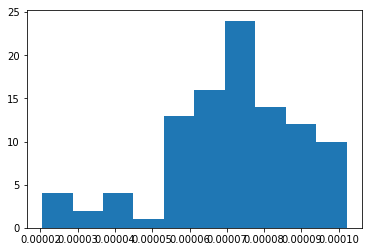

In [63]:
plt.hist(kdist)

In [64]:
# estimated dimension of the manifold supporting the data
Dmed = median(kdist)

from scipy.optimize import fsolve

f = lambda d: d*log(Dmed*sqrt(pi)) - special.loggamma(d)-log(log(2))+log(n)
est_dim = fsolve(f, 28*28)

# est_dim = log(n) / log(mean(kdist))

print("estimated dimension of the manifold supporting the data: ", est_dim)

estimated dimension of the manifold supporting the data:  [1.27929335]


In [65]:
fakeDim = 28*28
fakeX = rand(trainingSet.X.shape[0], fakeDim)
M = 100
J = random.choice(range(len(testingSet.target)), M, replace=False)
k = 1
fakekdist = zeros(M)
for i in range(M):
    newX = rand(1, fakeDim)
    alldists = apply_along_axis( lambda x: norm(newX-x), axis=1, arr=fakeX)
    fakekdist[i] = sorted(alldists)[k]

(array([ 4.,  6.,  9., 20., 16., 18., 15.,  7.,  3.,  2.]),
 array([10.28909205, 10.33572082, 10.3823496 , 10.42897837, 10.47560715,
        10.52223592, 10.5688647 , 10.61549347, 10.66212225, 10.70875102,
        10.7553798 ]),
 <a list of 10 Patch objects>)

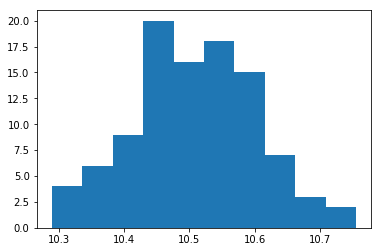

In [66]:
plt.hist(fakekdist)

In [93]:
fakeDmed = median(fakekdist)

f = lambda d: d*log(fakeDmed*sqrt(pi)) - special.loggamma(d/2+1)-log(log(2))+log(n)
est_dim = fsolve(f, 28*28)

# est_dim = log(n) / log(mean(kdist))

print("estimated dimension if the true dimension is really ", fakeDim, " : ", est_dim)

vb1 = exp((fakeDim/2*log(pi)-special.loggamma(fakeDim/2+1)))
u = fakeDmed
print("vb1: ", vb1, "u: ", u)
print("proba to be larger than median:", exp(-n * (u**fakeDim) * vb1) )

estimated dimension if the true dimension is really  50  :  [78.55065441]
vb1:  1.730219245836112e-13 u:  1.9218606737057904
proba to be larger than median: 0.0


In [72]:
fakeDim = 50
fakeX = rand(trainingSet.X.shape[0], fakeDim)
M = 100
J = random.choice(range(len(testingSet.target)), M, replace=False)
k = 1
fakekdist = zeros(M)
for i in range(M):
    newX = rand(1, fakeDim)
    alldists = apply_along_axis( lambda x: norm(newX-x), axis=1, arr=fakeX)
    fakekdist[i] = sorted(alldists)[k]

(array([ 1.,  1.,  2.,  3., 20., 22., 25., 20.,  3.,  3.]),
 array([1.58441277, 1.6408968 , 1.69738083, 1.75386486, 1.81034889,
        1.86683292, 1.92331695, 1.97980097, 2.036285  , 2.09276903,
        2.14925306]),
 <a list of 10 Patch objects>)

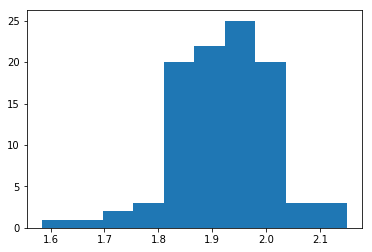

In [37]:
plt.hist(fakekdist)

In [42]:
sqrt(fakeDim)/trainingSet.X.shape[0]**(1/fakeDim)

5.674426527792628

In [56]:
from scipy import special
1/exp((fakeDim/2)*log(pi)-special.loggamma(fakeDim/2+1))

5779614360472.331

In [52]:
special.gamma(fakeDim/2+1)

1.5511210043330984e+25

In [60]:
from scipy.optimize import fsolve

f = lambda d: d*log(Dmed*sqrt(pi)) - special.loggamma(d)-log(log(2))+log(n)
fsolve(f, 28*28)

NameError: name 'func' is not defined